In [ ]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip the file from Google Drive into a directory in Colab
!unzip -q /content/drive/MyDrive/FER2013.zip -d /content/


In [ ]:
!ls /content/


drive  sample_data  test  train


In [ ]:
img_size = 224
batch_size = 16

train_data_dir = '/content/train'  # Update with correct subfolder if necessary
test_data_dir = '/content/test'    # Update with correct subfolder if necessary

datagen_train = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    channel_shift_range=0.0,
    fill_mode='nearest',
    horizontal_flip=True,
)

train_generator = datagen_train.flow_from_directory(
    train_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=True,
)

datagen_test = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    channel_shift_range=0.0,
    fill_mode='nearest',
    horizontal_flip=True,
)

test_generator = datagen_test.flow_from_directory(
    test_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=False,
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Class Distribution in Training Set:
angry: 3995 samples
disgust: 436 samples
fear: 4097 samples
happy: 7215 samples
neutral: 4965 samples
sad: 4830 samples
surprise: 3171 samples

Class Distribution in Test Set:
angry: 958 samples
disgust: 111 samples
fear: 1024 samples
happy: 1774 samples
neutral: 1233 samples
sad: 1247 samples
surprise: 831 samples


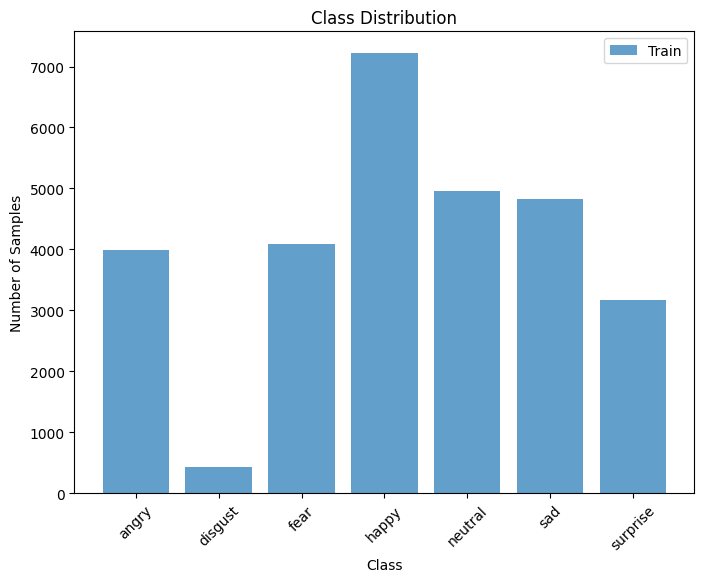

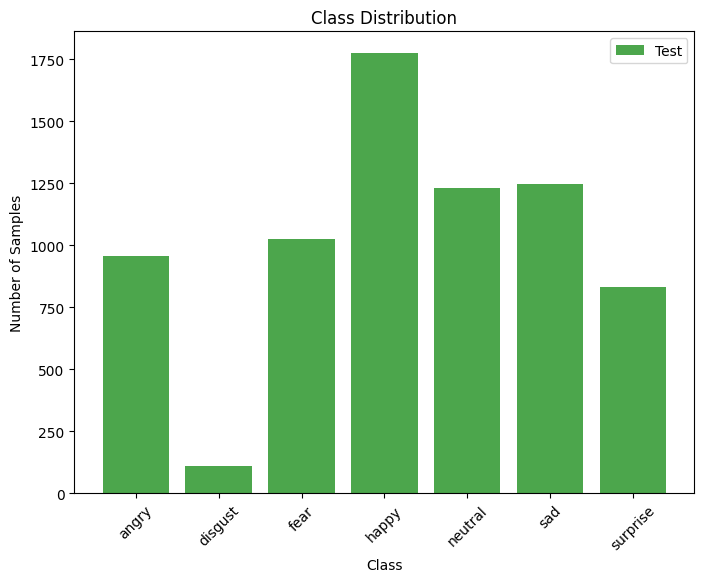

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Count the number of samples per class in the training set
train_class_counts = np.bincount(train_generator.classes)
test_class_counts = np.bincount(test_generator.classes)

# Print class distribution
print("Class Distribution in Training Set:")
for label, count in zip(class_labels, train_class_counts):
    print(f"{label}: {count} samples")

print("\nClass Distribution in Test Set:")
for label, count in zip(class_labels, test_class_counts):
    print(f"{label}: {count} samples")

# Optionally, plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(class_labels, train_class_counts, alpha=0.7, label='Train')
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(class_labels, test_class_counts, alpha=0.7, label='Test', color='green')
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Handeling class imbalance




*   Data Augmentation
*   Over_Sampling

*   class_Weights
*   Focal_Loss





## Data Augmentation

In [ ]:
datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Rescaling pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for the validation/test set (no augmentation)
datagen_val = ImageDataGenerator(rescale=1.0 / 255.0)

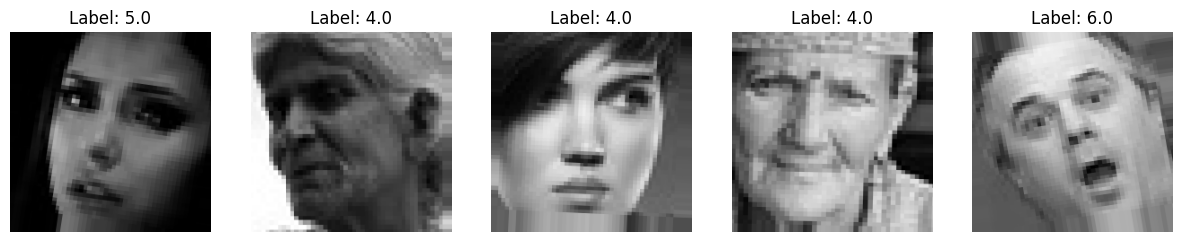

In [ ]:
def plot_images(generator, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Get a batch of images and labels
        img, label = next(generator)

        # Plot the first image in the batch
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img[0])  # Display the first image
        plt.title(f"Label: {label[0]}")  # Display the corresponding label
        plt.axis('off')  # Hide the axes
    plt.show()

# Visualize augmented training images
plot_images(train_generator, num_images=5)



In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers:
    layer.trainable = False

# Add layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
output = Dense(7, activation="softmax")(x)

model_vgg = Model(inputs=base_model.input, outputs=output)

model_vgg.compile(optimizer=Adam(learning_rate=0.0005),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
# Check the shape of labels from the training generator
img, label = next(train_generator)
print(label.shape)  # Should print (batch_size,) for sparse_categorical_crossentropy


(16,)


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    verbose=1,
    min_delta=0.02,
)

checkpoint_callback_val = tf.keras.callbacks.ModelCheckpoint(
    'best_VGG_val.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

checkpoint_callback_train = tf.keras.callbacks.ModelCheckpoint(
    'best_VGG_train.keras',
    monitor='accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
history = model_vgg.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[checkpoint_callback_val,checkpoint_callback_train,reduce_lr],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1794/1794 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.3585 - loss: 1.6250
Epoch 1: val_accuracy improved from -inf to 0.48186, saving model to best_VGG_val.keras

Epoch 1: accuracy improved from -inf to 0.40843, saving model to best_VGG_train.keras
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 510s 275ms/step - accuracy: 0.3586 - loss: 1.6249 - val_accuracy: 0.4819 - val_loss: 1.3759 - learning_rate: 5.0000e-04
Epoch 2/20
   1/1794 ━━━━━━━━━━━━━━━━━━━━ 2:31 85ms/step - accuracy: 0.5625 - loss: 1.3823

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.48186 to 0.70000, saving model to best_VGG_val.keras

Epoch 2: accuracy improved from 0.40843 to 0.56250, saving model to best_VGG_train.keras
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5625 - loss: 1.3823 - val_accuracy: 0.7000 - val_loss: 1.1494 - learning_rate: 5.0000e-04
Epoch 3/20
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.4711 - loss: 1.3799
Epoch 3: val_accuracy did not improve from 0.70000

Epoch 3: accuracy did not improve from 0.56250
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 461s 257ms/step - accuracy: 0.4711 - loss: 1.3799 - val_accuracy: 0.5126 - val_loss: 1.3042 - learning_rate: 5.0000e-04
Epoch 4/20
   1/1794 ━━━━━━━━━━━━━━━━━━━━ 2:10 73ms/step - accuracy: 0.3125 - loss: 1.4284
Epoch 4: val_accuracy improved from 0.70000 to 0.90000, saving model to best_VGG_val.keras

Epoch 4: accuracy did not improve from 0.56250
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3125 - loss: 1.4284 - val_accuracy: 0.9000 

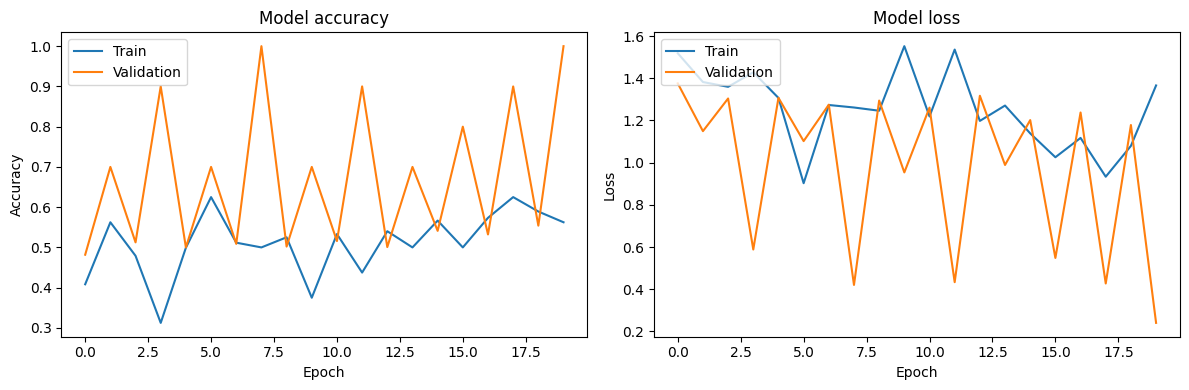

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()